# Plateau angle simulation
## Goal
The goal of this part is to create a simulation of the relationship between inputs and the motor angles. To do so, a neural network will be trained, using pytorch, in order to simulate the system.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *

## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
dt = 0.007

In [4]:
name_list = os.listdir('src/data/train')
datas = [pd.read_csv('src/data/train/{}'.format(x)) for x in name_list]

Data visualisation

<IPython.core.display.Javascript object>


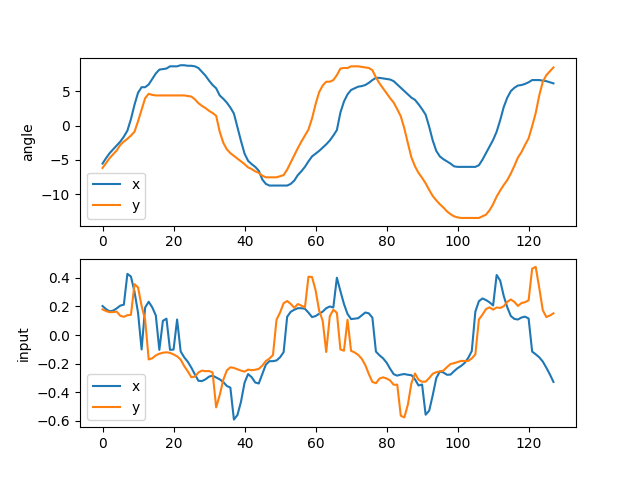

<IPython.core.display.Javascript object>


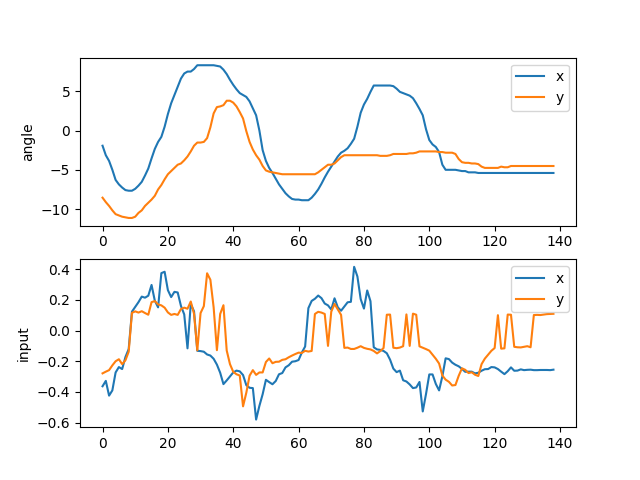

In [5]:
for data in datas:
    fig, axs = plt.subplots(2, 1)
    
    axs[0].plot(data['angle_x'], label='x')
    axs[0].plot(data['angle_y'], label='y')
    axs[0].set_ylabel('angle')
    axs[0].legend()
    
    axs[1].plot(data['input_x'], label='x')
    axs[1].plot(data['input_y'], label='y')
    axs[1].set_ylabel('input')
    axs[1].legend()
    
    plt.show()

The input of the NN will be the inputs and speed. Thus, it is computed for each dataset.

The prediction of the neural network will be the speed to the next timestep.

All datasets are concatened and shuffled in order to have no-biased gradients during the training

Since the data is symetrical, it is possible to double it by adding the opposite measurements

<IPython.core.display.Javascript object>


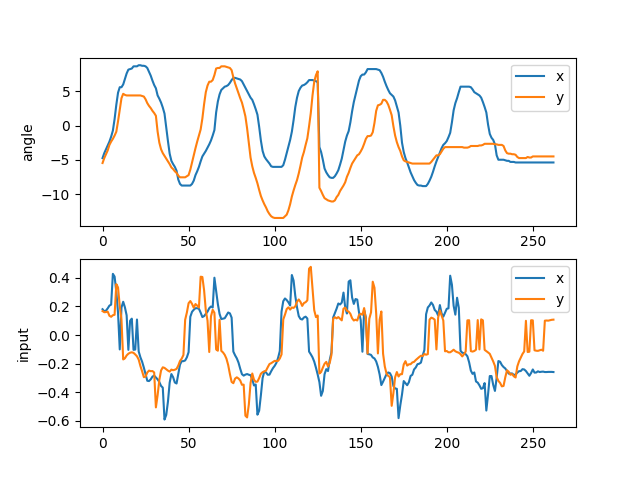

In [6]:
for data in datas:
    data['d_angle_x'] = (data['angle_x'] - data['angle_x'].shift(1)) / dt
    data['d_angle_y'] = (data['angle_y'] - data['angle_y'].shift(1)) / dt
    data['target_x'] = data['d_angle_x'].shift(-1)
    data['target_y'] = data['d_angle_y'].shift(-1)
    
    data.dropna(inplace=True)
    
data = datas[0]
#data = data.append(datas[0].mul(-1.))
for df in datas[1:]:
    data = data.append(df)
    #data = data.append(df.mul(-1.))
#data = data.sample(frac=1)
data.reset_index(inplace=True)
fig, axs = plt.subplots(2, 1)
    
axs[0].plot(data['angle_x'], label='x')
axs[0].plot(data['angle_y'], label='y')
axs[0].set_ylabel('angle')
axs[0].legend()
    
axs[1].plot(data['input_x'], label='x')
axs[1].plot(data['input_y'], label='y')
axs[1].set_ylabel('input')
axs[1].legend()
    
plt.show()

<IPython.core.display.Javascript object>


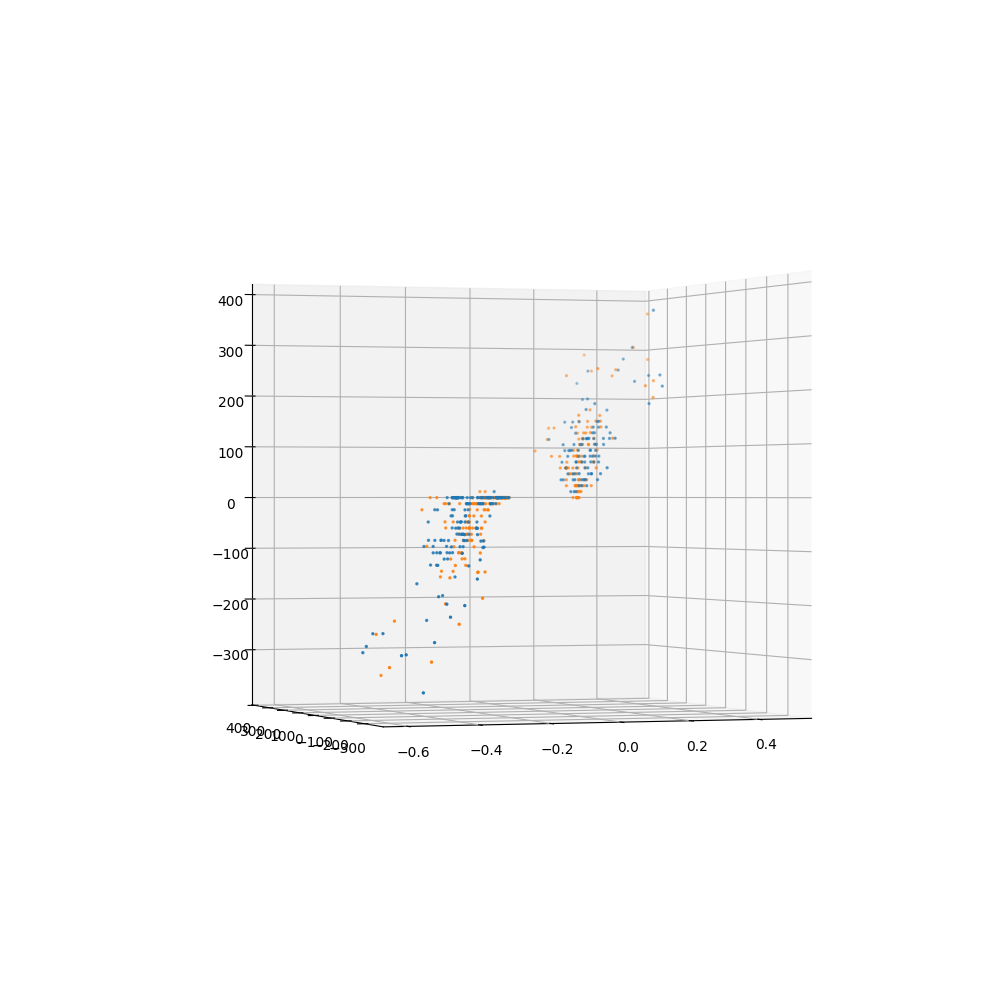

/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [7]:
plt.figure()
plt.scatter(data['input_x'], data['target_x'], s=2)
plt.scatter(data['input_y'], data['target_y'], s=2)
plt.show()

ax = plt.axes(projection='3d')
ax.view_init(0, -110)
ax.scatter3D(data['input_x'], data['d_angle_x'], data['target_x'], s=2)
ax.scatter3D(data['input_y'], data['d_angle_y'], data['target_y'], s=2)
ax.figure.set_size_inches(10, 10)
plt.show()

In [8]:
data.head()

,index,x,y,angle_x,angle_y,input_x,input_y,d_angle_x,d_angle_y,target_x,target_y
0,1,-0.026,-0.033,-4.741,-5.464,0.181,0.168,114.857143,103.428571,103.285714,103.285714
1,2,-0.021,-0.027,-4.018,-4.741,0.166,0.160,103.285714,103.285714,80.428571,80.285714
2,3,-0.016,-0.022,-3.455,-4.179,0.171,0.161,80.428571,80.285714,80.285714,80.428571
3,4,-0.010,-0.018,-2.893,-3.616,0.187,0.164,80.285714,80.428571,80.428571,114.857143
4,5,-0.004,-0.013,-2.330,-2.812,0.206,0.135,80.428571,114.857143,103.285714,68.857143


In [9]:
len(data)

263

## Physical Model
In this section, the motor dynamics will be derived from the physic. The produced model will be the benchmark for the next steps.

### Equations
The speed equation of a DC motor is:
n = (V_m - R_m * I_a) / k_b / W_b

Since I_a is our only dynamic variable, we can symplify this equation to:
n = a * x + b
which is a simple linear regression.

Many models are proposed

In [10]:
# Motor_x and y independant
A_x = np.ones((len(data), 2))
A_x[:, 1] = data['input_x'].to_numpy()
B_x = data['target_x'].to_numpy().reshape(-1, 1)

A_y = np.ones((len(data), 2))
A_y[:, 1] = data['input_y'].to_numpy()
B_y = data['target_y'].to_numpy().reshape(-1, 1)

# Identical motor hypothesis
A = np.vstack((A_x, A_y))
B = np.vstack((B_x, B_y))


phy_motor_x = LinearRegression().fit(A_x, B_x)
phy_motor_y = LinearRegression().fit(A_y, B_y)
phy_motor = LinearRegression().fit(A, B)

print("Ide motor\nx coefs:", phy_motor_x.coef_, "  ", phy_motor_x.score(A_x, B_x))
print("y coefs: ", phy_motor_y.coef_, "\n")
print("Identical hyp\nCoefs: ", phy_motor.coef_, "  ", phy_motor_x.score(A_y, B_y))

Ide motor
x coefs: [[  0.         397.77686522]]    0.8233397376524638
y coefs:  [[  0.         416.27994947]] 

Identical hyp
Coefs:  [[  0.         404.93030948]]    0.8038166192447452


Let's test those models

It is possible to see some steady state error. Using the 3D plot, it is possible to see that the inertia component of the motor is missing. Thus, the transition regimes must be unaccurate.

It is also possible to use a simplified model, without an intercept (symetric)

Finally, it seems usless to treat each motor independentely

Leading to:

n = (V_m - R_m * I_a) / k_b / W_b + n * coef

=>   n = a * x + b

In [11]:
# Inertia motor
A = np.vstack((data[['input_x', 'd_angle_x']].to_numpy(), data[['input_y', 'd_angle_y']].to_numpy()))
A[:, 1] = A[:, 1] / 100

phy_motor_inertia = LinearRegression().fit(A, B)

print("Inertia motor\nx coefs:", phy_motor_inertia.coef_)

Inertia motor
x coefs: [[230.73007689  47.36354957]]


In [12]:
def recurcive_predict(s_0: float, a_u: float, a_s: float, u: np.ndarray) -> np.ndarray:
    s = np.zeros_like(u)
    s[0] = s_0  
    for i in range(1, len(u)):
        s[i] = a_u * u[i-1] + a_s / 100. * s[i-1]
    return s  

In [13]:
for df in datas:
    df['y_hat_x_phy_motor_x'] = df['input_x'].to_numpy() * phy_motor_x.coef_[0][1]
    df['y_hat_y_phy_motor_y'] = df['input_y'].to_numpy() * phy_motor_y.coef_[0][1]
    
    df['y_hat_x_phy_motor'] = df['input_x'].to_numpy() * phy_motor.coef_[0][1]
    df['y_hat_y_phy_motor'] = df['input_y'].to_numpy() * phy_motor.coef_[0][1]
    
    df['y_hat_x_motor_inertia'] = recurcive_predict(df['d_angle_x'].iloc[0], phy_motor_inertia.coef_[0][0], phy_motor_inertia.coef_[0][1], df['input_x'].to_numpy())
    df['y_hat_y_motor_inertia'] = recurcive_predict(df['d_angle_y'].iloc[0], phy_motor_inertia.coef_[0][0], phy_motor_inertia.coef_[0][1], df['input_y'].to_numpy())
    
    df['angle_hat_x_phy_motor_x'] = s_to_p(df['angle_x'].iloc[0], df['y_hat_x_phy_motor_x'].to_numpy(), dt)
    df['angle_hat_y_phy_motor_y'] = s_to_p(df['angle_y'].iloc[0], df['y_hat_y_phy_motor_y'].to_numpy(), dt)
    
    df['angle_hat_x_phy_motor'] = s_to_p(df['angle_x'].iloc[0], df['y_hat_x_phy_motor'].to_numpy(), dt)
    df['angle_hat_y_phy_motor'] = s_to_p(df['angle_y'].iloc[0], df['y_hat_y_phy_motor'].to_numpy(), dt)
    
    df['angle_hat_x_phy_motor_inertia'] = s_to_p(df['angle_x'].iloc[0], df['y_hat_x_motor_inertia'].to_numpy(), dt)
    df['angle_hat_y_phy_motor_inertia'] = s_to_p(df['angle_y'].iloc[0], df['y_hat_y_motor_inertia'].to_numpy(), dt)

# Neural network training
Since the motors behavior isn't linear, multiples NN are created and trained to model the system.

Due to the previous overvations, both motors have been considered identical.

The inputs and targets are converted into pytorch format

In [14]:
x_np = np.vstack(
            (data[['input_x', 'd_angle_x']].to_numpy(), data[['input_y', 'd_angle_y']].to_numpy())
        )
x_np[:, 1] = x_np[:, 1] / 100

x = Variable(
    torch.from_numpy(
        x_np
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(
        np.vstack(
            (data[['target_x']].to_numpy(), data[['target_y']].to_numpy())
        )
    ).type(torch.FloatTensor)
)

In [15]:
nets = [PlateauNet1Hidden(2, 8, 1), PlateauNet1Hidden(2, 16, 1), PlateauNet1Hidden(2, 32, 1), 
        PlateauNet1Hidden(2, 64, 1), PlateauNet2Hidden(2, 8, 8, 1), PlateauNet2Hidden(2, 16, 8, 1),
       PlateauNet2Hidden(2, 32, 16, 1), PlateauNet2Hidden(2, 64, 32, 1), PlateauNet2Hidden(2, 64, 64, 1)]

In [16]:
nets = [train_model(net, x, y, n_epoch=10000) for net in nets]

tensor(1616.9156, grad_fn=<MseLossBackward>) 0.8089115284881783
tensor(1643.5651, grad_fn=<MseLossBackward>) 0.8056773155229139
tensor(1536.8433, grad_fn=<MseLossBackward>) 0.8183828971313643
tensor(1519.2568, grad_fn=<MseLossBackward>) 0.8207299168853268
tensor(361.1072, grad_fn=<MseLossBackward>) 0.9632770377820595
tensor(367.3779, grad_fn=<MseLossBackward>) 0.9625917048914835
tensor(354.9156, grad_fn=<MseLossBackward>) 0.9639076513405954
tensor(351.6433, grad_fn=<MseLossBackward>) 0.9642659462520702
tensor(352.1417, grad_fn=<MseLossBackward>) 0.9642040351366848


In [25]:
best_index = 6

for df in datas:
    df['y_hat_x_motor_nn'] = nets[best_index].recurcive_predict(df['d_angle_x'].iloc[0], df['input_x'].to_numpy())
    df['y_hat_y_motor_nn'] = nets[best_index].recurcive_predict(df['d_angle_y'].iloc[0], df['input_y'].to_numpy())
    
    df['angle_hat_x_nn'] = s_to_p(df['angle_x'].iloc[0], df['y_hat_x_motor_nn'].to_numpy(), dt)
    df['angle_hat_y_nn'] = s_to_p(df['angle_y'].iloc[0], df['y_hat_y_motor_nn'].to_numpy(), dt)

## Tests

<IPython.core.display.Javascript object>


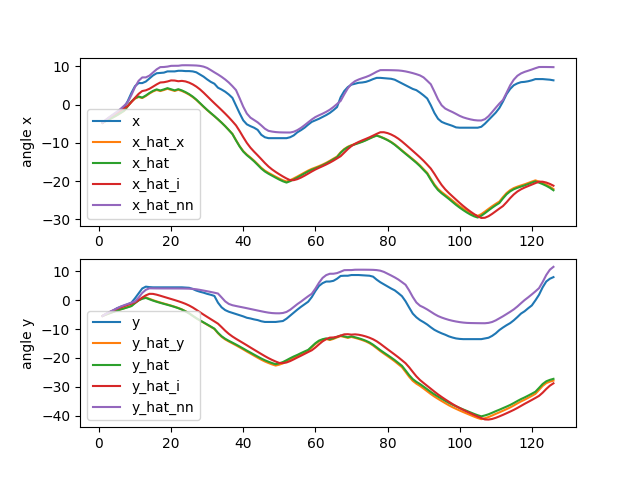

<IPython.core.display.Javascript object>


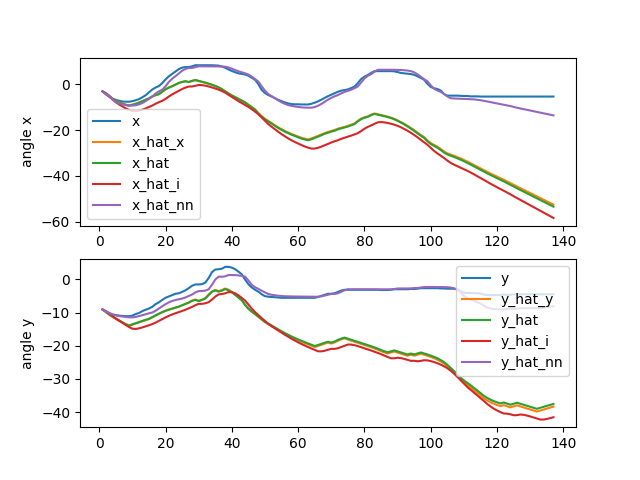

In [26]:
for df in datas:
    fig, axs = plt.subplots(2, 1)
    
    axs[0].plot(df['angle_x'], label='x')
    axs[0].plot(df['angle_hat_x_phy_motor_x'], label='x_hat_x')
    axs[0].plot(df['angle_hat_x_phy_motor'], label='x_hat')
    axs[0].plot(df['angle_hat_x_phy_motor_inertia'], label='x_hat_i')
    axs[0].plot(df['angle_hat_x_nn'], label='x_hat_nn')
    
    axs[0].set_ylabel('angle x')
    axs[0].legend()
    
    axs[1].plot(df['angle_y'], label='y')
    axs[1].plot(df['angle_hat_y_phy_motor_y'], label='y_hat_y')
    axs[1].plot(df['angle_hat_y_phy_motor'], label='y_hat')
    axs[1].plot(df['angle_hat_y_phy_motor_inertia'], label='y_hat_i')
    axs[1].plot(df['angle_hat_y_nn'], label='y_hat_nn')
    axs[1].set_ylabel('angle y')
    axs[1].legend()

In [27]:
torch.save(nets[best_index], 'src/data/motor_nn.pt')

## Conclusion
Given those results, the best motor is the neural network.

Here is the visualisation of its behavior topology

In [28]:
net = torch.load('src/data/motor_nn.pt')

X = np.arange(-5, 5, 0.1)
Y = np.arange(-400, 400, 1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[net.step(x, y / 100.).item() for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

<IPython.core.display.Javascript object>


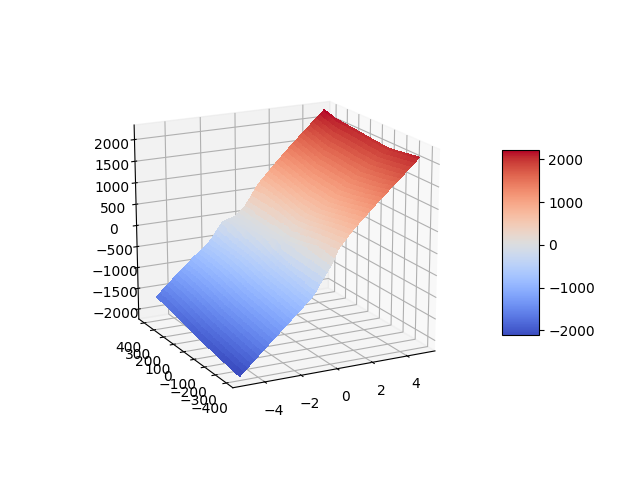

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(30, -70)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()